## Jupyer Notebook using ESRI built-in [Spark](https://spark.apache.org/).

This notebook is borrowed from Mansour's github [ESRI Spark notebook](https://github.com/mraad/spark-esri)  to demonstrate the spatial binning of Cobb Accident data around 1978-2018. Mansour's notebook create the spatila bining inside ArcGIS Pro. What I tried is using notebook outside ArcGIS Pro.  

About half milliion records.

Create a new conda environment and activate it to use this notebook, as follows:

- Start a `Python Command Prompt` from `Start > ArcGIS`.

- Execute the following:

```
conda create --yes --name spark_esri --clone arcgispro-py3
activate spark_esri
pip install pyarrow
```

### Import the modules.

In [37]:
import os
import arcpy
from python.sparkInit import spark_start, spark_stop
fc= r'C:\projects\ESRICrash\CobbDatafgdb.gdb\accidentsReports'

### Start a Spark instance.

Note the `config` argument to [configure the Spark instance](https://spark.apache.org/docs/latest/configuration.html).

In [38]:
config = {"spark.driver.memory":"2G"}
spark = spark_start(config=config)

### Read the selected Broadcast feature shapes in WebMercator SR.

It is assumed that you added to the map the `Broadcast` point feature class from the download `miami.gdb`.

Note that the `SearchCursor` is subject to the user selected features, and to an active query definition in the layer properties. For Example, set the query definition to `Stauts = 0: Under way using engine` to get the location of all moving ships, in such that we get a "heat map" of the port movement.

In [39]:
#fc= r'C:\Users\zhangc\Documents\ArcGIS\Projects\sparkesri\Zone17_2013_09.gdb\Zone17_2013_09_Broadcast'

sp_ref = arcpy.SpatialReference(3857)
data = arcpy.da.SearchCursor(fc,["SHAPE@X","SHAPE@Y"],spatial_reference=sp_ref)
#data = arcpy.da.SearchCursor("Broadcast",["SHAPE@X","SHAPE@Y"],spatial_reference=sp_ref)

### Create a Spark data frame of the read data, and create a view named 'v0'.

In [40]:
spark\
    .createDataFrame(data,"x double,y double")\
    .createOrReplaceTempView("v0")

### Aggregate the data at 200x200 meters bins.

The aggregation is performed by Spark as a SQL statement in a parallel share-nothing way and the resulting bins are collected back in the `rows` array variable.

This is a nested SQL expression, where the inner expression is mapping the input `x` and `y` into `q` and `r` cell locations given a user defined bin size, and the outter expression is aggreating as a sum the `q` and `r` pairs. Finally, `q` and `r` are mapped back to `x` and `y` to enble the placement on a map. 

In [41]:
cell0 = 50.0 # meters
cell1 = cell0 * 0.5

rows = spark\
    .sql(f"""
select q*{cell0}+{cell1} x,r*{cell0}+{cell1} y,least(count(1),1000) as pop
from
(select cast(x/{cell0} as long) q,cast(y/{cell0} as long) r from v0)
group by q,r
""")\
    .collect()

### Create an in-memory point feature class of the collected bins.

The variable `rows` is an array of form `[[x0,y0,pop0],[x1,y1,pop1],...,[xN,yN,popN]]`.

In [42]:
ws = "memory"
nm = "Bins"

fc = os.path.join(ws,nm)

arcpy.management.Delete(fc)

sp_ref = arcpy.SpatialReference(3857)
arcpy.management.CreateFeatureclass(ws,nm,"POINT",spatial_reference=sp_ref)
arcpy.management.AddField(fc, "POP", "LONG")

with arcpy.da.InsertCursor(fc, ["SHAPE@X","SHAPE@Y", "POP"]) as cursor:
    for row in rows:
        cursor.insertRow(row)

### Apply a naturalbreak classification to highlight the bins.

In [43]:
print (os.path.join(ws,nm))

memory\Bins


In [8]:
#_ = arcpy.ApplySymbologyFromLayer_management(fc, f"{nm}.lyrx")

In [75]:
import pandas as pd
from arcgis.gis import GIS
#from arcgis.widgets import MapView

In [76]:
gis = GIS()
m_map = gis.map(location = 'Marietta, GA', zoomlevel = 10)
#m_map

In [77]:
# load your feature class into a spatially enabled dataframe (sedf)
m_sedf = pd.DataFrame.spatial.from_featureclass(fc)
# plot the sedf on your map
m_sedf.spatial.plot(map_widget = m_map,
        renderer_type='c',  # for class breaks renderer
        method='esriClassifyNaturalBreaks',  # classification algorithm
        class_count=5,  # choose the number of classes
        col='POP',  # numeric column to classify
#        cmap='Dark2',  # color map to pick colors from for each class
        cmap='prism',  # color map to pick colors from for each class
        alpha=0.7  # specify opacity
       )
 # show the map
# mapview=MapView(gis=gis, item=m_sedf)
# mapview.legend=True
# mapview
m_map

MapView(layout=Layout(height='400px', width='100%'))

In [88]:
cbs_list = [1]
cmap_list = []
class_breaks = m_map.layers[0].layer.layerDefinition.drawingInfo.renderer.classBreakInfos
for cb in class_breaks:
    print(cb.description, cb.classMaxValue)  # print the class break labels
    cbs_list.append(cb.classMaxValue)
    cmap_list.append([x/255.0 for x in cb.symbol.color])


1.0 - 250.75 250.75
250.75 - 500.5 500.5
500.5 - 750.25 750.25
750.25 - 1000.0 1000.0
1000.0 - 1000.0 1000.0


Text(0.5, 1.0, 'Histogram of Bin counts')

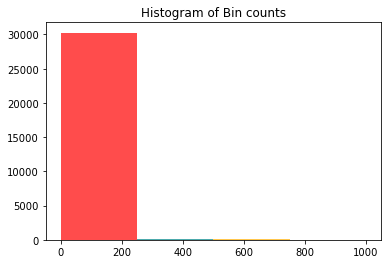

In [92]:
import matplotlib.pyplot as plt
import numpy as np
# build a histogram for the same class breaks
n, bins, patches = plt.hist(m_sedf['POP'], bins=cbs_list)

# apply the same color for each class to match the map
idx = 0
for c, p in zip(bins, patches):
    plt.setp(p, 'facecolor', cmap_list[idx])
    idx+=1
plt.title('Histogram of Bin counts')

### Stop the spark instance.

In [93]:
spark_stop()